<h1 style="font-size: 40px; margin-bottom: 0px;">5.2 Python image analysis (II)</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 800px;"></hr>

In notebook 5-1, we started exploring how images are represented on our computers by playing around with them in Python. Today, we'll take what we know about how images are represented to extract quantitative information from our images and use that information to analyze our images to derive biological insights. First, we'll load in the single set of serum-starved and serum-stimulated cells that we worked with in in notebook 5-1, then run through an analysis to quantify the nuclear intensity of YAP after serum stimulation. Then, you'll work with a full dataset to then determine if there is a significant difference in YAP nuclear localization. 

<strong>Learning objectives:</strong>
<ul>
    <li>Continue exploring images in Python</li>
    <li>Extract quantitative information from images</li>
    <li>Analyze a single image</li>
    <li>Run an analysis on a full dataset</li>
</ul>

In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

#These two packages are for image processing and analysis
import skimage as ski
import scipy.ndimage as ndi

#This built-in package is for using regular expressions (regex) in Python 
import re

<h1 style="font-size: 40px; margin-bottom: 0px;">Extract quantitative information from images</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 850px;"></hr>

To get us started for today's lesson, let's quickly load in our image files from before. For convenience, the code is included below using the set up from our class demo:

In [2]:
#Same code as from 5-1
file_names = [name for name in os.listdir('./data') if '.tiff' in name]
no_serum_names = [name for name in file_names if 'no-serum' in name]
no_serum_names.sort()
serum_names = [name for name in file_names if 'no-serum' not in name]
serum_names.sort()

no_serum = np.zeros(len(no_serum_names), dtype=object)
serum = np.zeros(len(serum_names), dtype=object)

for i in range(0, len(no_serum_names), 1):
    no_serum[i] = plt.imread(f'./data/{no_serum_names[i]}')
    serum[i] = plt.imread(f'./data/{serum_names[i]}')

<h2>Plot the intensity profile</h2>

Since our images are 2D arrays, we can pull out rows and columns and then plot the resulting intensities along that axis as a line plot to visualize the intensity profile. Select an image from the ones that we've imported, and then see if you can plot an intensity profile for a single row or column from that image.

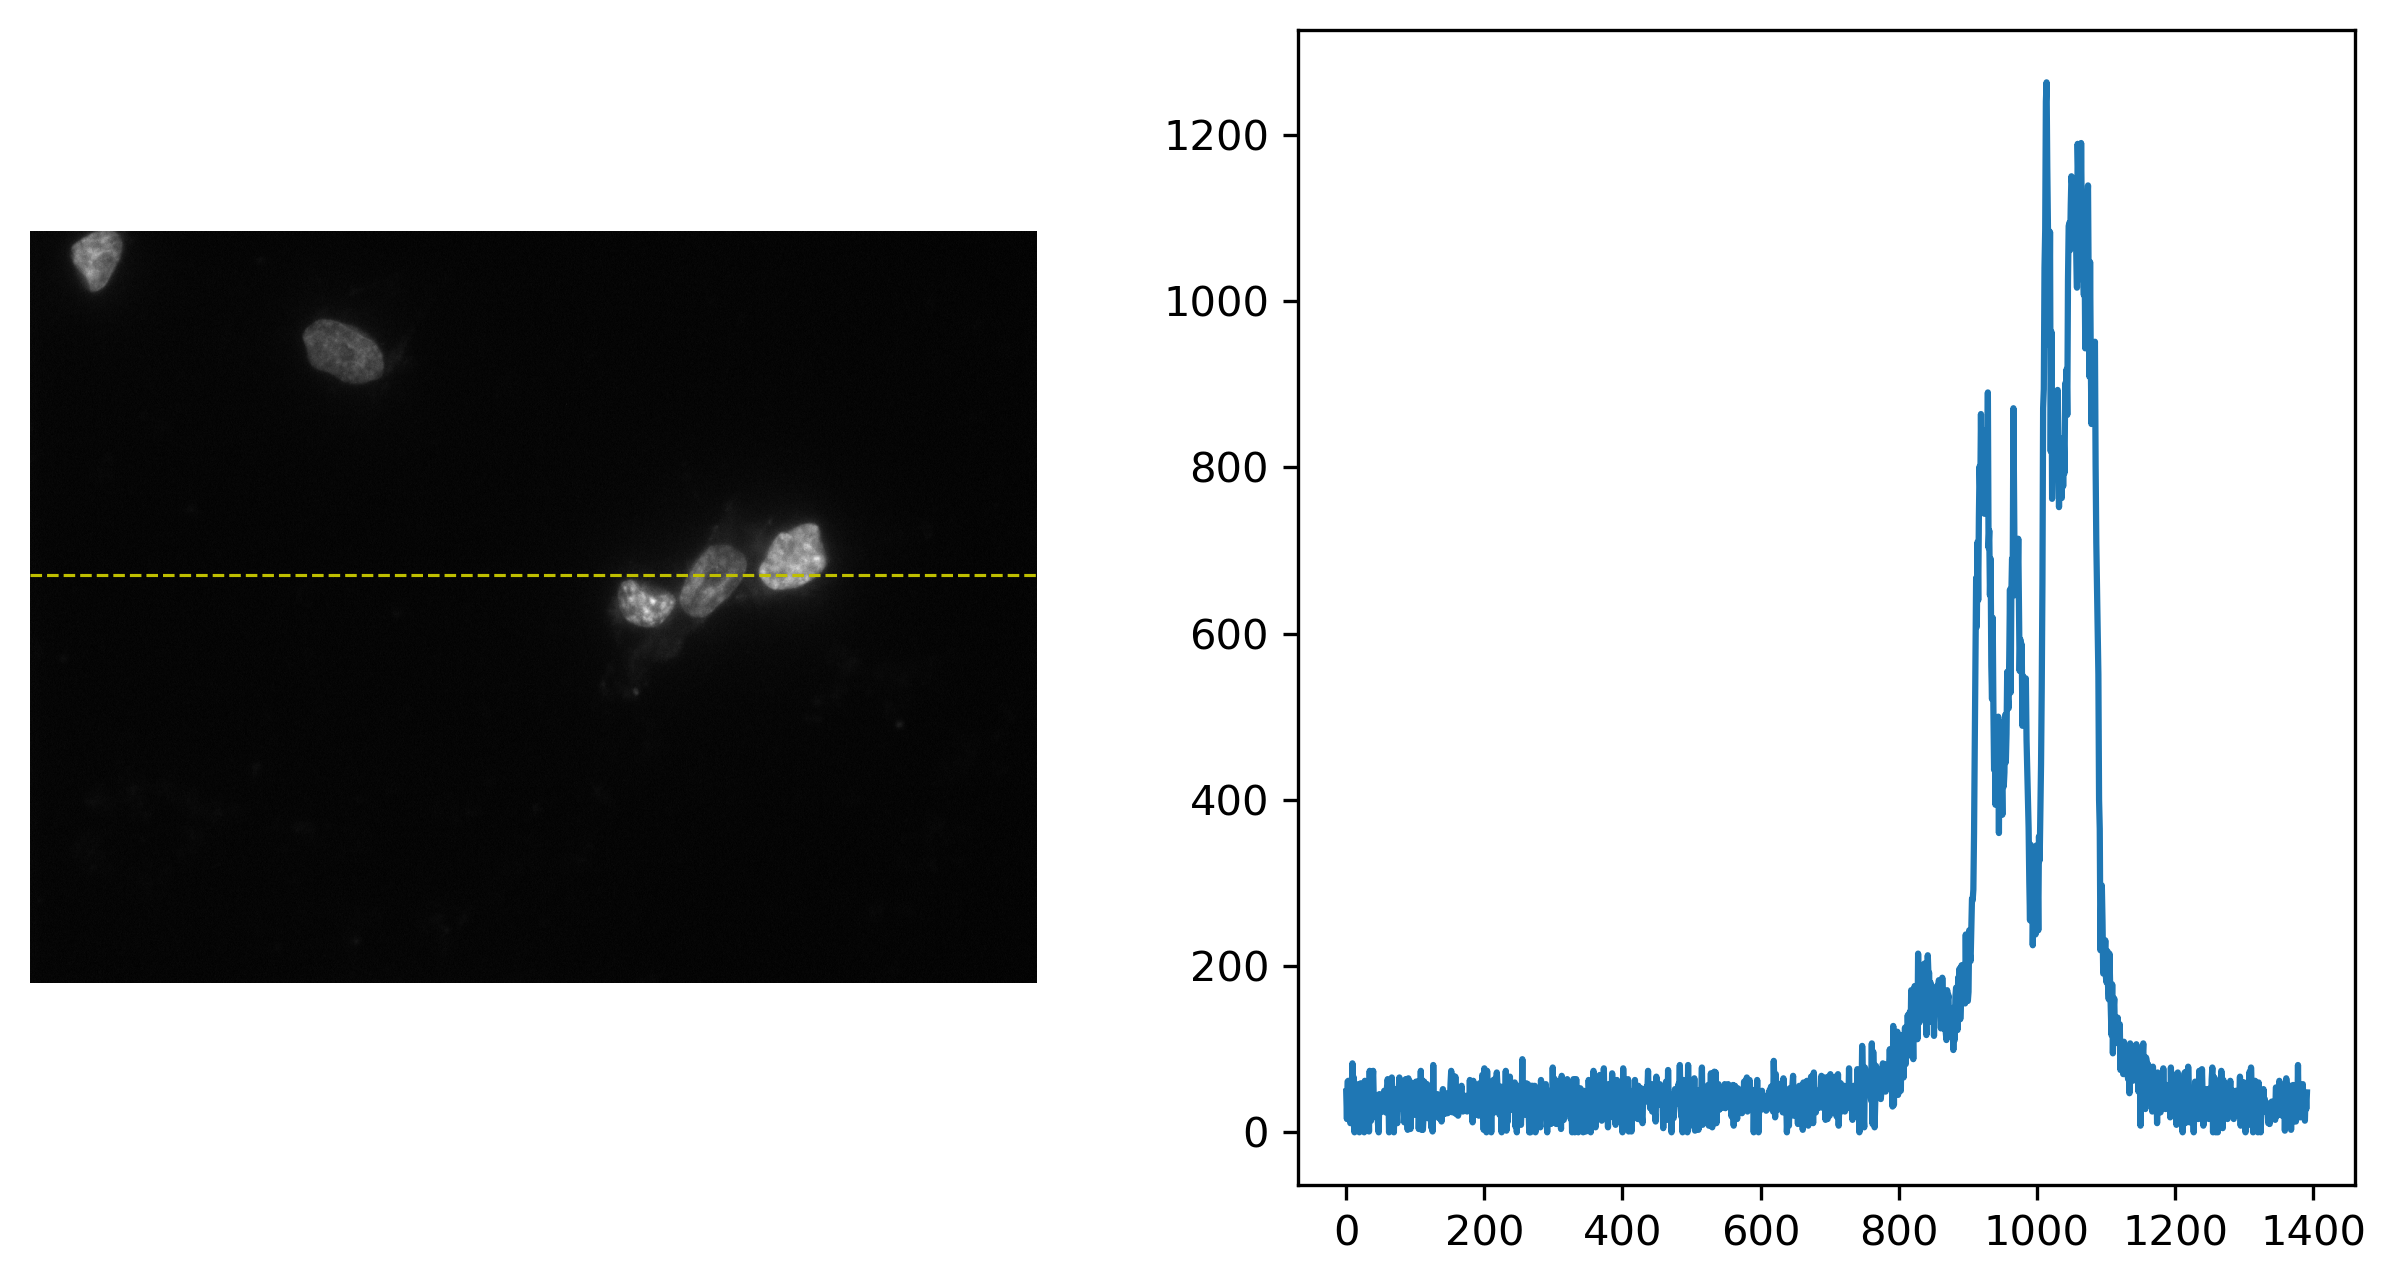

In [13]:
#Set up our figure area with 2 subplots
fig, ax = plt.subplots(1, 2)

#For easy updating what row we pull and plot
pull_row = 475

#Have our image next to our intensity profile
ax[0].imshow(no_serum[0],
             cmap='gray'
            )

#Mark the row we are pulling on our image
ax[0].hlines(pull_row,
             0,
             len(no_serum[0][pull_row, :]),
             color='y',
             ls='--',
             lw=0.75,
            )
#Tidy up image
ax[0].axis(False)

#Plot the intensity profile as a line plot
sns.lineplot(no_serum[0][pull_row, :],
             ax=ax[1]
            )

#This here is part of demo for edge detection
#To show why we don't see edges detected with default parameters for canny function
#B/c the default parameters use the full bit depth value space
#Whereas our image value range is a very small fraction of that
#Setting ymax to max 16bit value shows how our image uses a very small portion of the full value space
#So default canny parameters will not detect edges, and we will need to adjust low and high threshold for canny
# ax[1].set_ylim(0, 2**16)

#Tidy up plots
fig.set_size_inches(10, 5)
fig.set_dpi(300)
plt.show()

<h2>Detect edges</h2>

The quantitative values of our images can be used to determine where edges exist in our images, and we can make use of scikit-image's <code>ski.feature.canny()</code> edge detector function to identify where the edges are. <a href="https://scikit-image.org/docs/0.25.x/api/skimage.feature.html#skimage.feature.canny" rel="noopener noreferrer"><u>Documentation for <code>ski.feature.canny()</code> can be found here.</u></a>

This function allows us to set the thresholds for what is considered an edge as well as smooth out noise if our images are noisy, resulting in edges being detected where they don't actually exist.

In [10]:
#Just noting the full 16bit value space
print(2**16)

65536


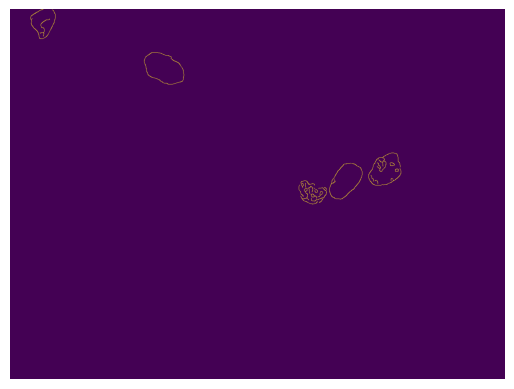

In [17]:
#Play around with parameters for canny function
edges = ski.feature.canny(no_serum[0], #image
                          sigma=1.75, #gaussian blur (reduces noise to smooth out image before edge detection to reduce small peaks picked up)
                          low_threshold=100, #low threshold for what is delta gray value
                          high_threshold=450, #high threshold for what is delta gray value
                         )

plt.imshow(edges)
plt.axis(False);

<h2>Identify particles in an image</h2>

Like with ImageJ, we can also create a binary image to then analyze the properties of the particles selected by our threshold. To do this, let's first process our two DAPI images again.

In [18]:
#Threshold using conditional statement and threshold value we used in 5-1
#And then fill holes
ns_thresh = no_serum[0] > 400
ns_thresh_fill = ndi.binary_fill_holes(ns_thresh)

s_thresh = serum[0] > 400
s_thresh_fill = ndi.binary_fill_holes(s_thresh)

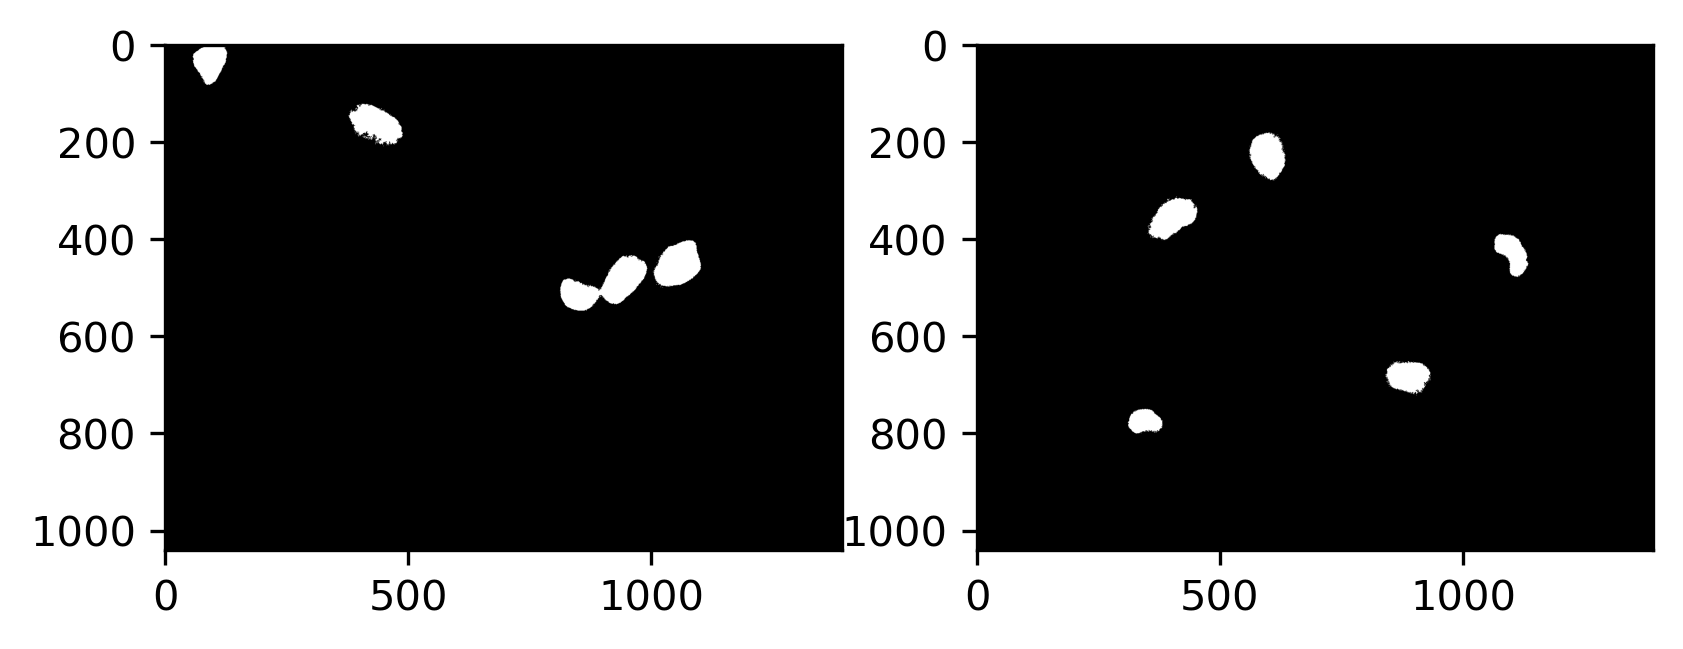

In [20]:
#Generate subplots for both thresholded DAPI channels
fig, ax = plt.subplots(1, 2)

ax[0].imshow(ns_thresh_fill,
             cmap='gray',
            )

ax[1].imshow(s_thresh_fill,
             cmap='gray',
            )

fig.set_dpi(300);

<h3>Remove particles on the image edge</h3>

Sometimes it can be helpful to also remove particles that are clipped by the boundaries of our image so that we exclude them from our analysis. In one of our images, we can see that there is a nucleus that is right on the edge. This could potentially throw off our results since we're not capturing the full nucleus. We can remove this particle by using <code>ski.segmentation.clear_border()</code>, which will remove particles that tough the edges of our image and is similar to what you can also do in ImageJ. <a href="https://scikit-image.org/docs/0.25.x/api/skimage.segmentation.html#skimage.segmentation.clear_border" rel="noopener noreferrer"><u>Documentation for <code>ski.segmentation.clear_border()</code> can be found here.</u></a>

In [21]:
#We have a nucleus on the top left of no serum DAPI channel
#We can use scikit-image to remove that nucleus via a simple function call
ns_thresh_fill = ski.segmentation.clear_border(ns_thresh_fill)

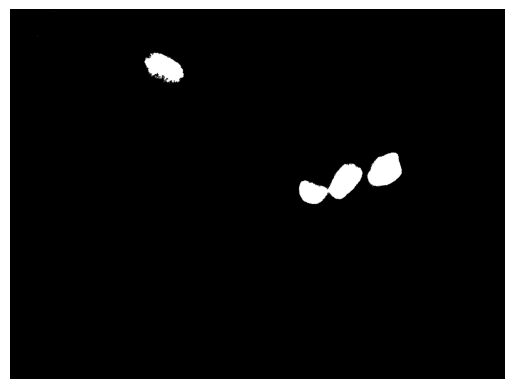

In [22]:
#Visualize image after we remove the nucleus that is clipped by the image boundary
plt.imshow(ns_thresh_fill,
           cmap='gray'
          )
plt.axis(False);

Once we have our processed binaries, we can use scikit-image's <code>ski.measure.label()</code> function to identify and also label individual particles in our thresholded images. <a href="https://scikit-image.org/docs/0.25.x/api/skimage.measure.html#skimage.measure.label" rel="noopener noreferrer"><u>Documentation for <code>ski.measure.label()</code> can be found here.</u></a>

Digging into the documentation, we can see that this function works by assigning any element in our 2D matrix with the value <code>0</code> as background pixels by default, and then it identifies particles as clusters of connected elements that share the same value, which in our case is <code>1</code>. Then after it identifies particles, it will assign each particle its own integer label.

If we dig into the documentation, we can see that it returns to us one object by default (<code>labels</code>), which is the labeled array where each particle is assigned an integer value. We can also instruct it to return an additional object (<code>num</code>), which is just the total particle count if we switch the parameter <code>return_num</code> from <code>False</code> to <code>True</code>.

In [23]:
#Use scikit-image to label all the particles (even the tiny noise)
ns_label, ns_particle_count = ski.measure.label(ns_thresh_fill,
                                                return_num=True
                                               )

s_label, s_particle_count = ski.measure.label(s_thresh_fill,
                                              return_num=True
                                             )

Now let's take a look at the objects it's returned to us.

In [24]:
print(ns_label)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


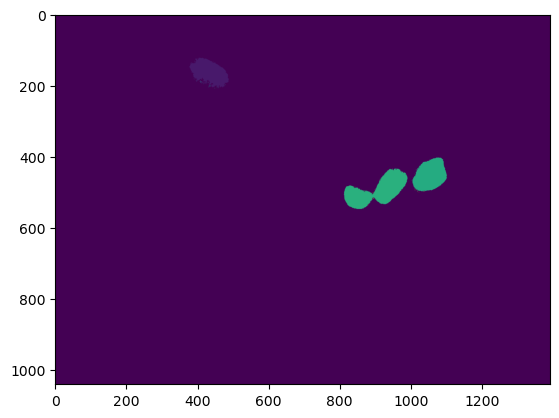

In [26]:
#Just taking a look
plt.imshow(ns_label)

In [25]:
#We told label function to return to us the total number of particles as well
print(ns_particle_count)
#Can see that there are a lot more particles labeled than we have nuclei
#This means we have noise that got picked up by our threshold

44


<h3>Visualize labeled particles</h3>

We can then take the new array containing our labeled particles. First, we can assign a color to each particle based on their label using <code>ski.color.label2rgb()</code>, which will allow us to differentiate each particle based on their assigned color. <a href="https://scikit-image.org/docs/0.25.x/api/skimage.color.html#skimage.color.lab2rgb" rel="noopener noreferrer"><u>Documentation for <code>ski.color.label2rgb()</code> can be found here.</u></a>

In [ ]:
#Add color to our labeled particles using this function
#Just for visualization purposes to more clearly see the different particles as different colors
ski.color.label2rgb(ns_label)

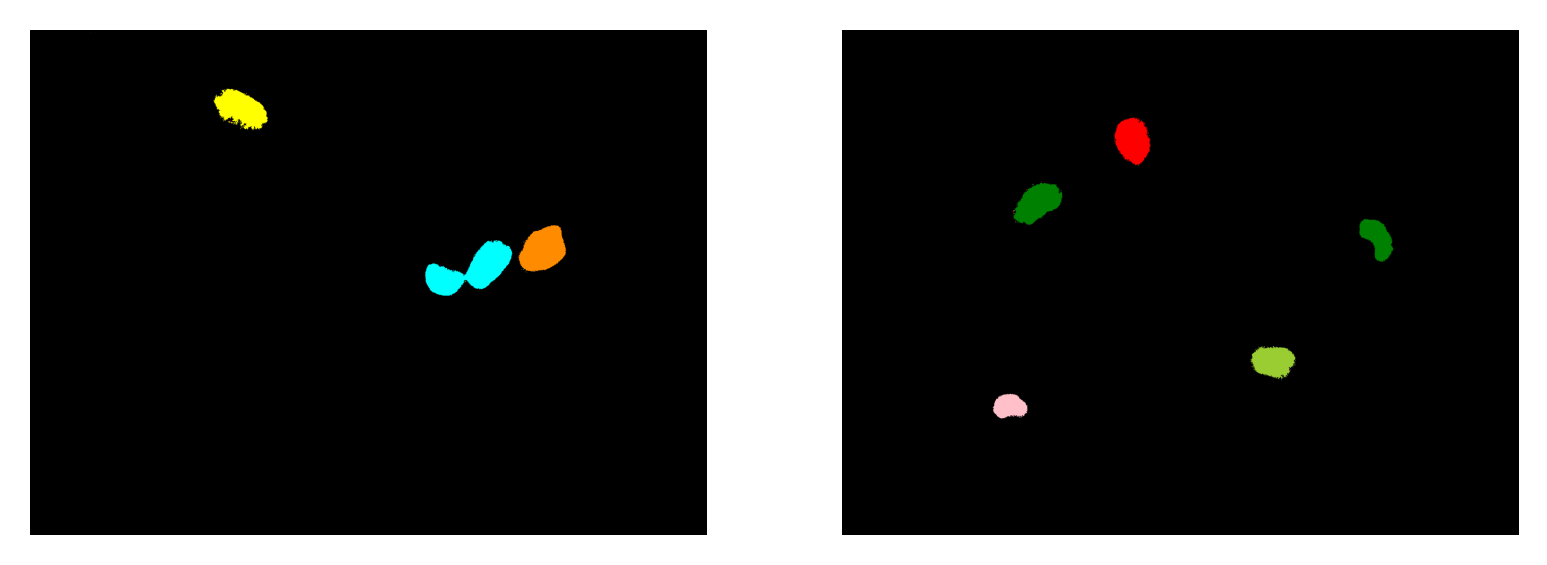

In [29]:
#Visualize
fig, ax = plt.subplots(1, 2)

ax[0].imshow(ski.color.label2rgb(ns_label))
ax[1].imshow(ski.color.label2rgb(s_label))

ax[0].axis(False)
ax[1].axis(False)

fig.set_dpi(300);

<h2>Analyze particles</h2>

With our labeled particles, we can continue to make use of scikit-image to now analyze the labeled particles. To do this, we'll use the <code>ski.measure.regionprops()</code> function, which will measure a bunch of properties of each labeled particle. <a href="https://scikit-image.org/docs/0.25.x/api/skimage.measure.html#skimage.measure.regionprops" rel="noopener noreferrer"><u>Documentation for <code>ski.measure.regionprops()</code>, including the full set of properties that it measures, can be found here.</u></a>

In [32]:
#Basically like the ImageJ analyze particles tool
ns_properties = ski.measure.regionprops(ns_label)
s_properties = ski.measure.regionprops(s_label)

Now let's take a look at the resulting object that we have as a result of this function:

In [33]:
#Object is compound data type with a bunch of RegionProperties objects
print(ns_properties)

[<skimage.measure._regionprops.RegionProperties object at 0x78b2a8150050>, <skimage.measure._regionprops.RegionProperties object at 0x78b2b2812490>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150110>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150210>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150310>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150450>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150550>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150650>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150750>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150410>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150910>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150a10>, <skimage.measure._regionprops.RegionProperties object at 0x78b2a8150b10>, <skimage.measure._regionprops.RegionP

We can see that each element is a RegionProperties object corresponding to a labeled particle that was analyzed. If we dig into the documentation for <code>ski.measure.regionprops()</code>, we can see under Notes that there are a bunch of properties that can be access as attributes or keys. These include <code>area</code> and <code>label</code>, which are most relevant to our analysis today.

Let's pull out these two attributes for a particle that we analyzed:

In [47]:
#We can pull out a single RegionProperty object and then pull out its area attribute
print(s_properties[0].area)

5207.0


<h3>Pull particle areas</h3>

You can see that we're able to access the quantified area of each particle by the <code>area</code> attribute, and if we wanted to then pull together all the areas of our analyzed particles, we can iterate through our list of <code>RegionProperties</code> objects that was outputed by the <code>ski.measure.regionprops()</code> function.

In [41]:
#Check to see if we have same number of particles picked up by our thresholds
#different, so we can set up two for-loops to iterate through each one
print(ns_particle_count == s_particle_count)

False


In [48]:
#Initialize arrays
ns_areas = np.zeros(ns_particle_count)
s_areas = np.zeros(s_particle_count)

#Run for loops to pull out area
for i in np.arange(0, ns_particle_count, 1):
    ns_areas[i] = ns_properties[i].area

for j in np.arange(0, s_particle_count, 1):
    s_areas[j] = s_properties[j].area

Let's take a look at the measure areas for our particles.

In [49]:
#Pull areas together into single dataframe
area_data = pd.DataFrame([ns_areas, s_areas], 
                         index=['No Serum', 'Serum']
                        )
area_data = area_data.T

area_data.style

,No Serum,Serum
0,1.000000,5207.000000
1,1.000000,1.000000
2,5779.000000,1.000000
3,1.000000,1.000000
4,1.000000,1.000000
5,1.000000,1.000000
6,1.000000,2.000000
7,1.000000,1.000000
8,1.000000,1.000000
9,4.000000,1.000000


<h3>Filter out noise</h3>

We can see that there are a lot of particles with just a size of 1 or are otherwise very small. This tells us that potentially, our thresholding picked up some noise as well. Let's take a look at the distribution of our particle areas.

<Axes: ylabel='Count'>

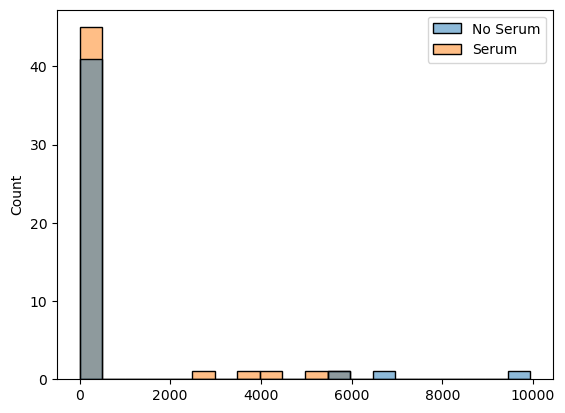

In [50]:
#Taking a look at distribution of pixel intensities
sns.histplot(area_data)
#Can see that most particles are noise
#The "true" nuclei are the larger particles

You can see that we have a fair number of tiny tiny particles with an area of less than 100 sq pixels, which probably correspond to noise (since we wouldn't expect our nuclei to be that small). So this isn't something we want to include in our analysis. So what we can do is make use of a conditional statement to filter out particles based on whether or not their area meets our threshold to not be considered noise.

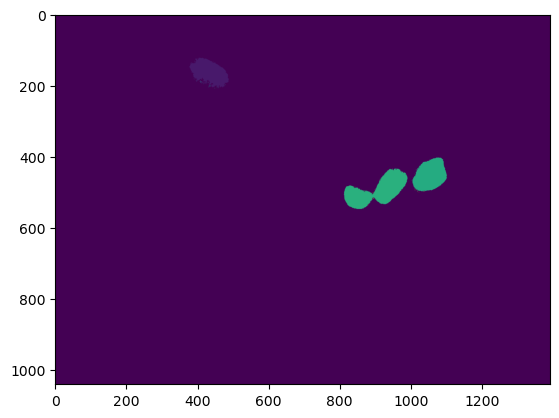

In [51]:
plt.imshow(ns_label)

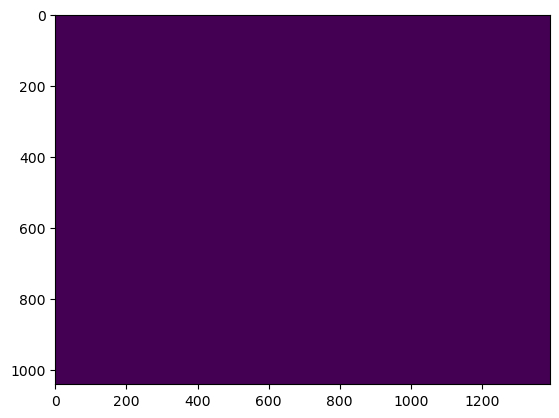

In [53]:
#Example showing that we can set up an "empty" image
#Just a 2D matrix of zeros
#Kind of like how we have arrays to hold our data
#We will move our nuclei into this "empty" image if they meet a size criteria
#Basically setting a min particle size in ImageJ analyze particles tool
ns_filtered = np.zeros_like(ns_label)
s_filtered = np.zeros_like(s_label)

plt.imshow(ns_filtered)

In [58]:
#Reminder that we can pull area of each particle
ns_properties[2].area

np.float64(5779.0)

In [57]:
#We can also use label attribute to pull out the particle itself
print(ns_label == ns_properties[2].label)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [59]:
#Example of a single nucleus being pulled out by its label
#And then "transferred" over to our "empty" image
ns_filtered += ns_label == ns_properties[2].label

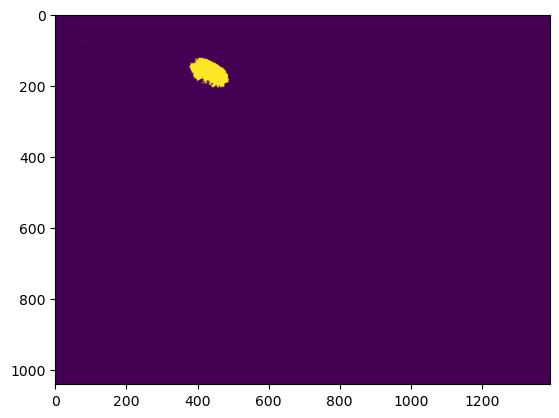

In [60]:
#Taking a quick look
plt.imshow(ns_filtered)

In [63]:
#Now we use a for-loop to go through all particles and pull out the real ones that correspond to actual nuclei
ns_filtered = np.zeros_like(ns_label)
s_filtered = np.zeros_like(s_label)

for i in ns_properties:
    #Set min particle size
    if i.area > 100:
        #Then move over to "empty" image if it is a real nucleus and not noise
        ns_filtered += ns_label == i.label

for j in s_properties:
    if j.area > 100:
        s_filtered += s_label == j.label

Let's take a look at our images after we filtered out the noise.

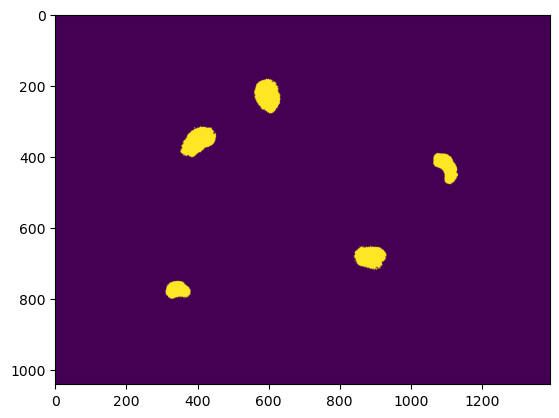

In [64]:
#Take a look at the final result after filtering out noise
plt.imshow(s_filtered)
#Won't look dramatically different since we just removed things that are an area of 1 sq pixel or so

Now that we've filtered out any noise, we can then relabel our particles again.

In [66]:
#We lose our labels when we filter b/c we used a conditional statement to find labels
#So the result is a 2D matrix of True and False rather than having label numbers
#So then we can just relabel everything again
ns_filtered_label, ns_filtered_count = ski.measure.label(ns_filtered,
                                                         return_num=True
                                                        )

s_filtered_label, s_filtered_count = ski.measure.label(s_filtered,
                                                       return_num=True
                                                      )

<h3>Separate particles using the watershed method</h3>

For one of our images, we can see that we have two nuclei that are close together, and as a result, they end up getting labeled together as well. We can separate out these nuclei so that they are instead understood as two separate particles rather than a single particle. There are a number of different ways to computationally separate out particles, and we'll be using the watershed method, which is available as a function in scikit-image <code>ski.segmentation.watershed()</code>. <a href="https://scikit-image.org/docs/0.25.x/api/skimage.segmentation.html#skimage.segmentation.watershed" rel="noopener noreferrer"><u>Documentation for <code>ski.segmentation.watershed()</code> can be found here.</u></a>

First, we'll prepare our filtered and labeled image for watershed by dilating our particles so that they are smoother, so the watershed function doesn't mistake small irregularities as things to segment. Let's take a look at our nuclei from our serum-starved cells.

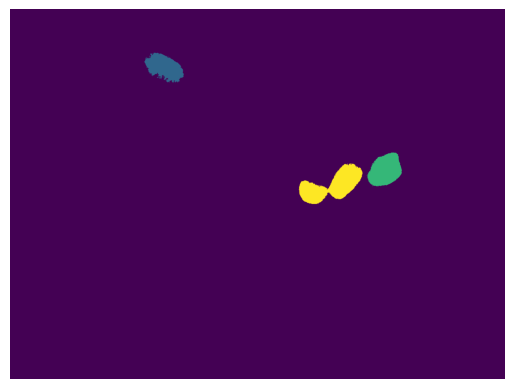

In [72]:
#Visualize labeled particles with viridis colormap
#Sufficient now to see different colors b/c value range of labels is just 1 through 4 covering the full viridis color space
plt.imshow(ns_filtered_label)
plt.axis(False);

#Can see that two nuclei are being labeled as one (share same color)

Let's apply a dilation to smooth out irregularities so that they don't interfere with our segmentation. We can make use of the <code>ski.morphology.dilation()</code> function that we used in notebook 5-1. There, we used this function as part of a process to fill holes, but here, we'll use it to smooth out the edges of our thresholded nuclei.

In [73]:
#First smooth out the rough edges since watershed method can pick up false particles if edges are rough/irregular
#We can use the same dilation function we used before in 5-1 but this time with a different footprint
ns_dilation = ski.morphology.dilation(ns_filtered_label, 
                                      footprint=np.ones((20,20))
                                     )

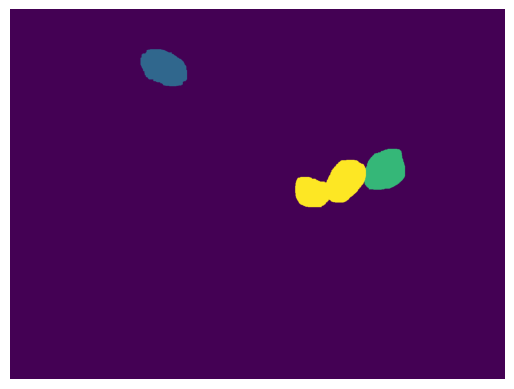

In [74]:
#Taking a look at dilation result
plt.imshow(ns_dilation)
plt.axis(False);
#Can see that edges are smoother

Then we can calculate the centers of our individual particles by calculating the distance within the particle from the edges (or background), which will give us an idea of where the center of each "true" particle should be. To do this, we'll make use of the <code>ndi.distance_transform_edt()</code> function, which calculates the Euclidean distance from the background. <a href="https://docs.scipy.org/doc//scipy-1.8.0/reference/generated/scipy.ndimage.distance_transform_edt.html" rel="noopener noreferrer"><u>Documentation for <code>ndi.distance_transform_edt()</code> can be found here.</u></a>

In [75]:
#Calculate the distance of each pixel from the background
#Basically within each particle, we're plottinw how far it is from the edges
#Allows us to estimate where the center of each "true" nuclei would be
distance = ndi.distance_transform_edt(ns_dilation)

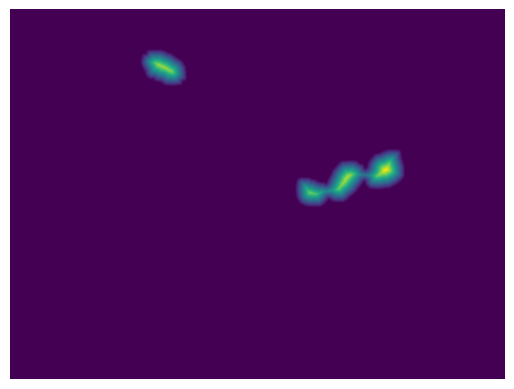

In [76]:
#We can visualize the distances by plotting them
plt.imshow(distance)
plt.axis(False);
#Can see that the approx. centers of what would be individual nuclei have the highest values b/c they are greatest distance from edge of particle

You can see that the regions of greatest distance from the background no have the highest value, which we can visualize with the viridis colormap. We can then identify the coordinates of the centers of each "true" particle by identifying where the local maxima are using the calculated distances. We'll make use of the <code>ski.feature.peak_local_max()</code> function, which will find the spots of highest value (peaks) and return their coordinates to us. <a href="https://scikit-image.org/docs/0.25.x/api/skimage.feature.html#skimage.feature.peak_local_max" rel="noopener noreferrer"><u>Documentation for <code>ski.feature.peak_local_max()</code> can be found here.</u></a>

In [77]:
#Since those centers have the greatest values, we can find their coordinates by calculating local maxima
coordinates = ski.feature.peak_local_max(distance,
                                         footprint=np.ones((30,30))
                                        )

In [81]:
#Our output is a set of coordinates corresponding to the local maxima
#Basically identifying where the centers of each individual nucleus should be
print(coordinates.T)

[[ 452  476  162  516]
 [1055  945  428  843]]


Then we'll take our coordinates and set them as points in a 2D matrix matching the shape of our labeled nuclei. These coordinates will determine where we want to initiate our watershed method.

In [82]:
#Then we plot the coordinates where they would be in our image
#Set up "empty" image to hold these dots
mask = np.zeros_like(ns_filtered_label)

#The 2D matrix is an 2D array of zeros ("empty" image)
#We find the coordinates as x,y positions and switch their value from 0 to 1
mask[tuple(coordinates.T)] = 1

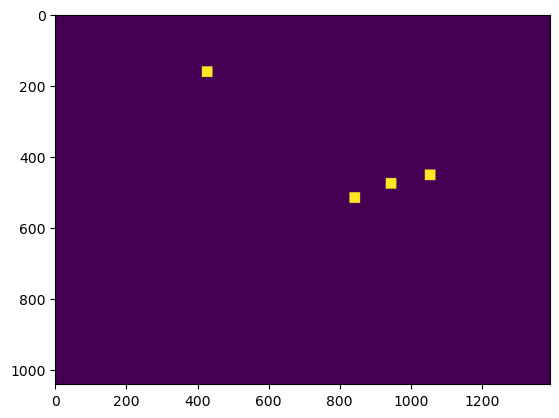

In [85]:
#This is just a visualization of where our centers were mapped to
#Using dilation while generating the image b/c 1 pixel is impossible to see
#So we blow it up to be 30x30sq so we can see where it is in our image
plt.imshow(ski.morphology.dilation(mask, footprint=np.ones((30,30)))
                                  )

We can then add labels to each coordinate point.

In [89]:
#Then we got to label our coordinates
#This time using scipy ndimage
markers, _ = ndi.label(mask)

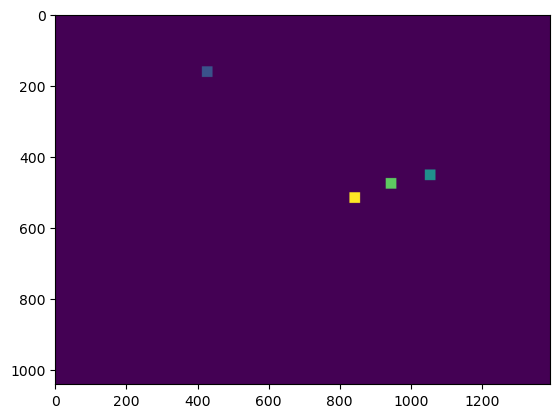

In [91]:
#Visualiation again now we can see the different labels as different colors in viridis colormap
plt.imshow(ski.morphology.dilation(markers, footprint=np.ones((30,30)))
          )

#Can see the two dots where our fused nuclei were are now identified with separate labels

With those coordinates set and labeled, we can then initiate the watershed using the <code>ski.segmentation.watershed()</code> function. <a href="https://scikit-image.org/docs/0.25.x/api/skimage.segmentation.html#skimage.segmentation.watershed" rel="noopener noreferrer"><u>Documentation for <code>ski.segmentation.watershed()</code> can be found here.</u></a>.

What we're doing is essentially identifying a local minimum, which we can set as the inverse of our local maxima, and then "flood" the region. We can also specify how much "flooding" we want to happen by using our original labeled nuclei as a mask.

In [94]:
#Now we initiate watershed
#It "floods" our image out from the center points we calculated
#And the "topology" is determined by our distance map, where we now invert it (maxima becomes minima)
#So kind of like filling up a watershed (environmental/ecological term)
watersh_label = ski.segmentation.watershed(-distance,
                                           markers=markers,
                                           mask=ns_filtered_label #Remove this parameter, and you can see the full flooding. This basically restricts flooding to our nuclei
                                          )

#Note how we set our mask parameter using our non-dilated binary
#We only used the dilated binary to make it easier to find the centers of our nuclei

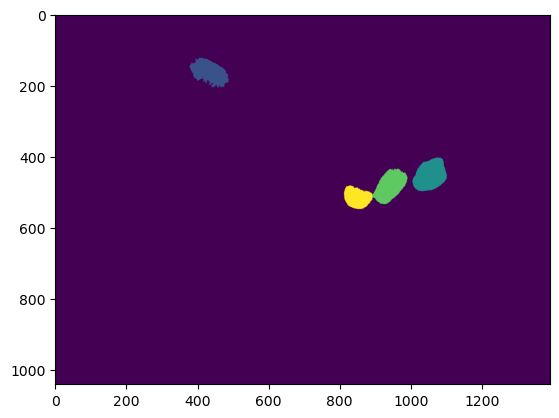

In [95]:
#Now visualize how our segmented nuclei look
plt.imshow(watersh_label)
#Can see now that the fused nuclei now have separate labels, indicating we've successfully segemented them from each other via watershed method

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #1: Pull out a single cell</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 850px;"></hr>

Now that we have our nuclei individually labeled, see if you can pull out a single nucleus and display a binary image of your single nucleus.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #2: Measure mean nuclear fluorescence</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 900px;"></hr>

Now that you're able to pull out a single nucleus at a time, see if you can then quantify the mean nuclear fluorescence for a single nucleus. Recall from 5-1 how you can use binary images as a mask, which will allow you to focus on just a particular region of interest, and you can apply this mask to the YAP channel.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #3: Analyze all nuclei in a single image</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 900px;"></hr>

See if you can set up a way to instead of manually analyzing a single nucleus one at a time, to analyze all the nuclei in a single image. Specifically for this exercise, see if you can analyze the mean nuclear YAP fluorescence intensity for all the nuclei in a single image, either the serum-starvation or the serum-stimulation condition.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #4: Perform statistical analysis</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 900px;"></hr>

Let's run a quick statistical analysis on our results from our single set of images.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #5: Run a full analysis</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 900px;"></hr>

For this exercise, let's take what we've learned for image analysis and set up a workflow for us to analyze a full set of fluorescence images to determine whether there is a significant increase in the nuclear intensity of YAP following serum stimulation.